In [61]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
from ripser import ripser
from persim import plot_diagrams, PersistenceImager
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL

from persim import plot_diagrams
from ripser import ripser, lower_star_img, Rips

import torch as tc
import torchvision as tv
import cv2 
from skimage import io
import skimage.morphology as morphology
import math
import pickle





In [62]:

path_to_dataset = r'../../Desktop/TDA/TDA_lower/' # Path to the downloaded and unzipped dataset

class OurDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path : str, mode : str="training"):
        self.dataset_path = dataset_path
        self.mode = mode # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "test")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path) # Założenie, że klasy reprezentowane są przez nazwy folderów
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}") # Mapowanie nazwy klasy do liczby

        # Utworzenie listy wszystkich przypadków treningowych (w praktyce robi się to w plikach zewnętrznych)
        # Utwórz listę zawierającą krotki, gdzie każda krotka zawiera parę (scieżka do zdjęcia, numeryczna reprezentacja klasy zdjęcia)
        self.cases = []
        for current_class in self.classes:
            for current_case in os.listdir(os.path.join(self.data_path, current_class)):
                case_path = os.path.join(self.data_path, current_class, current_case)
                self.cases.append((case_path, self.classes_dict[current_class]))
                # TODO - utworz odpowiednie krotki i dodaj je do listy self.cases

    def __len__(self):
        # Przeciążanie funkcji niezbędnej do określenia wielkości zbioru danych
        return len(self.cases)
        #raise NotImplementedError #TODO - wyznacz wielkosc aktualnie wczytywanego zbioru

    def __getitem__(self, idx):
        current_case = self.cases[idx]
        current_path = current_case[0]
        current_class = current_case[1]

        file = open(current_path, 'rb')
        current_input = pickle.load(file)
        current_input = current_input.reshape(1, 30, 30)
        current_input = current_input.astype(np.float32)

        return current_input, current_class
        

        

        return current_input, current_class


training_dataset = OurDataset(path_to_dataset, "training") # Utworzenie zbioru treningowego
testing_dataset = OurDataset(path_to_dataset, "testing") # Utworzenie zbioru testowego
batch_size = 16 # Okreslenie ile przypadkow ma byc naraz wczytywane i procesowane -> istotny hyperparameter w trakcie treningu
shuffle = True # Czy przypadki w każdej epocje mają być wczytywane losowo. Epoka - każdorazowe przeiterowanie przez cały zbiór treningowy



Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}
Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}


In [63]:
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=False)

In [64]:
class FirstModel(tc.nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()

        self.layer_1 = tc.nn.Sequential(
            tc.nn.Conv2d(1, 16, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(16),
            tc.nn.SiLU()
        ) 
        self.layer_2 = tc.nn.Sequential(
            tc.nn.Conv2d(16, 32, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(32),
            tc.nn.SiLU()
        )
        self.layer_max = tc.nn.Sequential(
            tc.nn.MaxPool2d(3, stride=2)
        )
        
        self.layer_3 = tc.nn.Sequential(
            tc.nn.Conv2d(32, 32, 3 , stride =1 , padding=1),
            tc.nn.BatchNorm2d(32),
            tc.nn.SiLU()
        )
        
        self.last_layer = tc.nn.Sequential(
            tc.nn.Flatten(),
            tc.nn.Linear(900, 128),
            tc.nn.SiLU()
            
        )
        self.last_layer_1 = tc.nn.Sequential(
            tc.nn.Flatten(),
            tc.nn.Linear(128, 32),
            tc.nn.SiLU()
            
        )

        self.last_layer_2 = tc.nn.Sequential(
            tc.nn.Flatten(),
            tc.nn.Linear(32,2),
            
        )

    def forward(self, x):
     
        x = self.last_layer(x)
        x = self.last_layer_1(x)
        x = self.last_layer_2(x)
        return x

In [65]:
model = FirstModel()
for images, classes in training_dataloader:
    output = model(images) # <- Kluczowa linijka kodu, wywołanie funkcji **forward** z klasy SimpleNetwork
    print(f"Output: {tc.nn.Sigmoid()(output)}") # <- w praktyce Sigmoid w celu wyznaczania prawdopodobieństwa umieszcza się poza siecią neuronową
    break

Output: tensor([[9.9517e-01, 9.6724e-01],
        [2.7213e-01, 1.5421e-02],
        [9.8286e-01, 9.7686e-01],
        [9.9737e-01, 9.9043e-01],
        [9.3458e-01, 2.6461e-01],
        [3.5799e-01, 1.9744e-01],
        [9.8674e-01, 9.0180e-01],
        [3.3079e-07, 9.1604e-01],
        [9.6818e-01, 1.7586e-02],
        [9.1471e-01, 7.6942e-01],
        [9.5754e-01, 3.2656e-01],
        [2.0389e-01, 2.7677e-01],
        [9.9636e-01, 2.0999e-01],
        [8.5703e-01, 1.6941e-01],
        [9.9519e-01, 8.3888e-01],
        [9.0891e-01, 9.9824e-01]], grad_fn=<SigmoidBackward0>)


In [66]:
learning_rate = 0.003 # Współczynnik uczenia, definiuje szybkość treningu, zbyt duży prowadzi do niestabilności, zbyt niski do wolnego uczenia
batch_size = 16 # Liczba obrazów analizowanych w zadanym momencie - większa wartość prowadzi do lepszego wykorzystania GPU, jednak może powodować większy potencjał do wpadania w minima lokalne
num_epochs = 100 # Liczba iteracji przez cały zbiór treningowy
objective_function = tc.nn.CrossEntropyLoss() # Funkcja kosztu, która będzie minimalizowana
model = FirstModel()
parameters = model.parameters() # Parametry, które będą optymalizowane w trakcie treningu sieci
#optimizer = tc.optim.Adam(parameters, lr=learning_rate) # Utworzenie obiektu optymalizatora -> w tym przypadku Adam (najpopularniejszy), w uproszczeniu - bardziej zaawansowany wariant spadku gradientowego
optimizer = tc.optim.SGD(model.parameters(), lr=0.002)
device = "cpu" # Urządzenie, na którym będzie prowadzony trening, użyjmy karty graficznej, ew. zmienić na "cpu" w przypadku jej braku. Karty graficzne są dostępnę na Google Colaboratory

training_dataset = OurDataset(path_to_dataset, "training")
test_dataset = OurDataset(path_to_dataset, "testing")
shuffle = True 
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = tc.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"





Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}
Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}


Dataset size: 431
Current epoch: 0
Current epoch loss: 31.418726291865944   Current validation loss: 0.6644785885184888
Current epoch: 1
Current epoch loss: 0.8626648805810792   Current validation loss: 0.4649380738900895
Current epoch: 2
Current epoch loss: 0.6435170082371086   Current validation loss: 3.9180429908069403
Current epoch: 3
Current epoch loss: 0.7584094666549612   Current validation loss: 0.43708012083322384
Current epoch: 4
Current epoch loss: 0.6204185210635104   Current validation loss: 0.46539040030659856
Current epoch: 5
Current epoch loss: 0.6188822854699225   Current validation loss: 0.9084562212804109
Current epoch: 6
Current epoch loss: 0.6004393276371701   Current validation loss: 0.880238331595443
Current epoch: 7
Current epoch loss: 0.5791819317573185   Current validation loss: 0.7497466828487094
Current epoch: 8
Current epoch loss: 0.5413456017760833   Current validation loss: 0.5830170135786865
Current epoch: 9
Current epoch loss: 0.5324820470920572   Curre

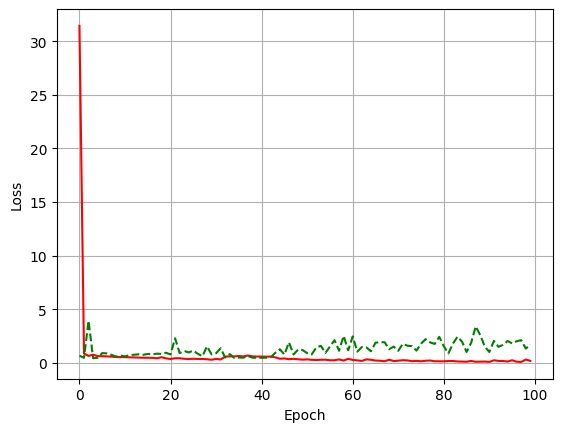

In [70]:
import torch.optim as optim
losses = []
val_losses = []
#optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_cen = tc.nn.CrossEntropyLoss()

#loss_cen = tc.nn.BCEWithLogitsLoss()
model = model.to(device) # Transfer sieci do pamięci urządzenia (np. GPU)

model.train()
print(f"Dataset size: {len(training_dataloader.dataset)}")
for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")
    epoch_loss = 0.0
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) # Transfer obrazów do pamięci urządzenia (np. GPU)
        output = model(images) # Przejście obrazów przez model
        loss = loss_cen(output, classes)# - wyznacz aktualna funkcje kosztu
        loss.backward() # - dokonaj backpropagacji gradientu wykorzystując wyznaczona wartosc kosztu
        optimizer.step()  # TODO - dokonaj aktualizacji optymalizatora
        optimizer.zero_grad()
        pass # TODO - wyzeruj historie gradientu w optymalizatorze
        epoch_loss += loss.item() * images.size(0)
    epoch_loss = epoch_loss / len(training_dataloader.dataset)
    losses.append(epoch_loss)
    val_loss = 0.0
    for images, classes in test_dataloader:
        images, classes = images.to(device), classes.to(device) # Transfer obrazów do pamięci urządzenia (np. GPU)
        output = model(images) # Przejście obrazów przez model
        loss = loss_cen(output, classes)# - wyznacz aktualna funkcje kosztu
        val_loss += loss.item() * images.size(0)
    val_loss = val_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)
    print(f"Current epoch loss: {epoch_loss}   Current validation loss: {val_loss}")

# Wizualizacja pętli treningowej
plt.figure()
plt.plot(losses, "r-")
plt.plot(val_losses, 'g--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Dataset size: 431
Accuracy = 0.9791183294663574
Recall = 0.9885057471264368


<Axes: >

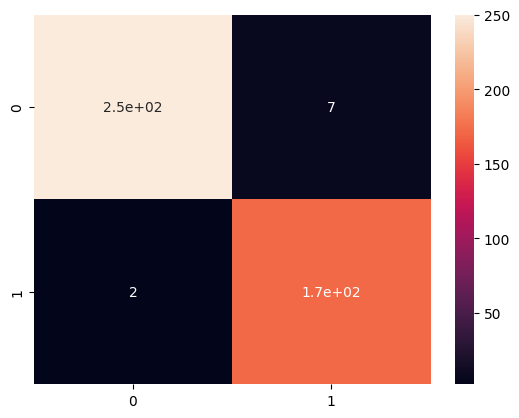

In [71]:
import sklearn.metrics as metrics
from torch import Tensor

predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(training_dataloader.dataset)}")
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device)
        output = model(images)
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)
        predictions.append(Tensor.cpu(prediction))
        targets.append(Tensor.cpu(classes))

pred = []
targ = []      
for i,j  in zip(predictions, targets):
  for a, b in zip(i, j):
    pred.append(a)
    targ.append(b)




cf_matrix = metrics.confusion_matrix(targ, pred)
print("Accuracy = " + str(metrics.accuracy_score(targ, pred)))
print("Recall = " + str(metrics.recall_score(targ, pred)))

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

Dataset size: 518
Accuracy = 0.581081081081081
Recall = 0.5776805251641138


<Axes: >

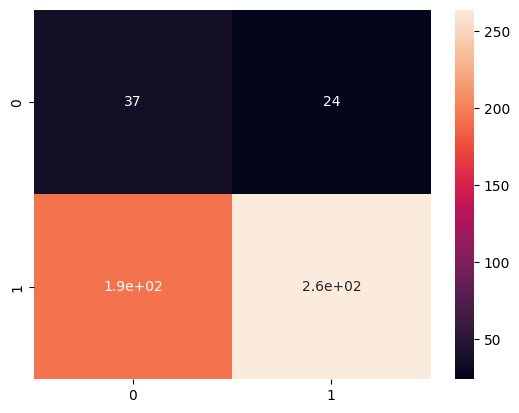

In [72]:
predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(testing_dataloader.dataset)}")
    for images, classes in testing_dataloader:
        images, classes = images.to(device), classes.to(device)
        output = model(images)
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)
        predictions.append(Tensor.cpu(prediction))
        targets.append(Tensor.cpu(classes))

pred = []
targ = []      
for i,j  in zip(predictions, targets):
  for a, b in zip(i, j):
    pred.append(a)
    targ.append(b)




cf_matrix = metrics.confusion_matrix(targ, pred)
print("Accuracy = " + str(metrics.accuracy_score(targ, pred)))
print("Recall = " + str(metrics.recall_score(targ, pred)))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)